In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
df = pd.read_csv('buzlanma_data.csv',sep=';')

# Veri Önişleme Adımları

In [3]:
df.head()

Veri_ID  Ilce      Veri_T Min_Hava_S_Z  Min_Hava_S Maks_Hava_S_Z  \
0   543258     5   7.06.2018        02:40       21.41         11:15   
1   341432     3   7.06.2013        05:56       18.56         14:26   
2   641706     6   8.03.2014        22:15        7.22         13:20   
3   341711     3  13.03.2014        23:57        5.76         10:32   
4   541274     5  31.12.2012        04:44        7.54         12:26   

   Maks_Hava_S  Ort_Hava_S Min_Nem_Z Min_Nem Maks_Nem_Z  Maks_Nem Ort_Nem  \
0        30.94       25.58     10:59    34.2      23:56      83.4   63.65   
1        26.58       22.23     15:55    40.2      05:59      80.6   62.14   
2        10.21        8.38     13:24   79.23      01:03     100.0   94.44   
3        10.09        7.68     16:32   48.22      02:52      83.4   68.35   
4        10.80        8.86     12:13   70.52      04:54      86.5   78.55   

  Min_RuzH_Z  Min_RuzH Maks_RuzH_Z  Maks_RuzH  Buzlanma  
0      02:13      0.00       15:55       6.05         0  
1      09:33      0.00       21:54       5.09         0  
2      02:13      0.00       14:54       5.81         0  
3      23:56      0.00       14:55       6.61         0  
4      10:24      0.69       13:32       6.93         0

In [4]:
df = df.sort_values(['Veri_T'])
df.reset_index(inplace=True)

## Tahmini yapılacak verilerin güncel veriler olacağından verileri tarih kolonuna sıraladık.
## Train de eski tarihe ait veriler olacak test de ise daha güncel veriler bulanacak bu sayede canlıda daha iyi çalışacağını tahmin ediyoruz.

In [5]:
def Tool(df, column, drop= True, Part= True): ## Sorted
    list = []
    for d in df[column]:
        day, month, year = d.split('.')
        if len(day) < 2:
            day = '0' + day
        time = f'{year}-{month}-{day}'
        list.append(time)   
    frame = pd.Series(list, name= 'time')
    frame = pd.to_datetime(frame) ## year, month, day
    frame = pd.DataFrame(frame, columns= ['time'])

    if drop:
        df.drop(column, axis= 1, inplace= True)

    df = pd.concat([df, frame], axis= 1)

    if Part:
        attr = ['Year', 'Month', 'Day']
        for a in attr:
            df['time' + f'_{a}'] = getattr(df['time'].dt, a.lower())    
    
    return df

df = Tool(df,'Veri_T')         

## Burda Tool ismindeki fonksiyonum ile Veri_T adlı kolonu yıl, ay ve gün olarak ayırdık.
## Burdan yılın belli tarih ve gün lerinden algoritmanın bir bağlantı yakalayacağını düşünüyoruz.

In [6]:
def One_Hot(df, columns, drop= True):
    from keras.utils import to_categorical
    data = df[columns].values
    encoded = to_categorical(data)

    if drop:
        df.drop(columns, axis= 1, inplace= True)

    encoded = pd.DataFrame(encoded)
    df = pd.concat([df, encoded], axis= 1) 

    return df

df = One_Hot(df, 'Ilce')

## One_Hot fonksiyonu ile ilçe verilerini vektör haline getirdik Algoritmaya besleyebilmek için.

In [7]:
index = df['Min_Hava_S_Z'][df['Min_Hava_S_Z'] == ' '].index
df = df.drop(index)

## Min_Hava_S_Z kolonundaki boşluk olan verileri attık.

In [8]:
index = df['Min_Nem_Z'][df['Min_Nem_Z'] == '///'].index[0]
df = df.drop(index)

## Min_Nem_Z kolonundaki anlamsız veriyi attık.

In [9]:
df.reset_index(inplace=True)

## DataFram' den veri attığım için index numaraları kaydı bunu düzeltmek için indexi resetledik.

In [10]:
def sec(df, columns, drop=True):
    for i in columns:
        list = []
        for j in df[i]:
            hour, minutes = j.split(':')
            sec = ((int(hour) * 60) + int(minutes)) * 60
            list.append(sec) 
        temp = pd.DataFrame(list,columns=[f'{i}_sec'])
        df = pd.concat([df, temp], axis= 1)

        if drop:
            df.drop(i, axis= 1, inplace= True)

    return df

columns = ['Min_Hava_S_Z', 'Maks_Hava_S_Z', 'Min_Nem_Z', 'Maks_Nem_Z', 'Min_RuzH_Z', 'Maks_RuzH_Z']
df = sec(df, columns)

## sec fonksiyonu ile saat/dk olan verileri saniye cinsine cevirdik. 

In [11]:
df.drop(['level_0','index','time','Veri_ID'], axis= 1, inplace= True)

## Kullanılmayacak kolonları dataFrameden çıkardık.

## Outlier ları gözlemleyebilmek için kolonları görselleştirdik.

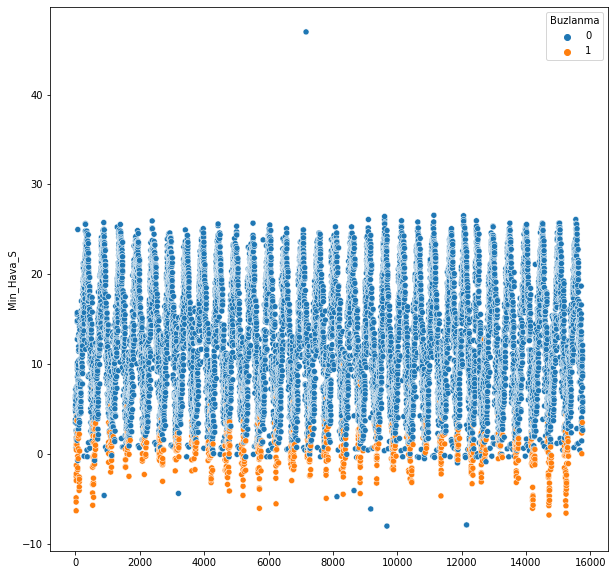

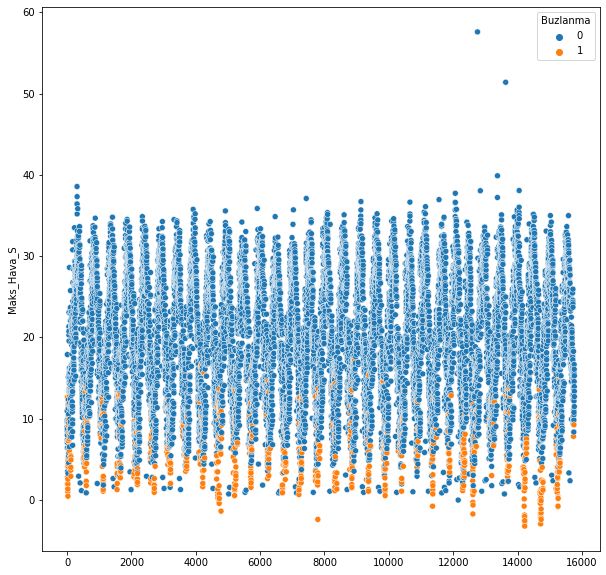

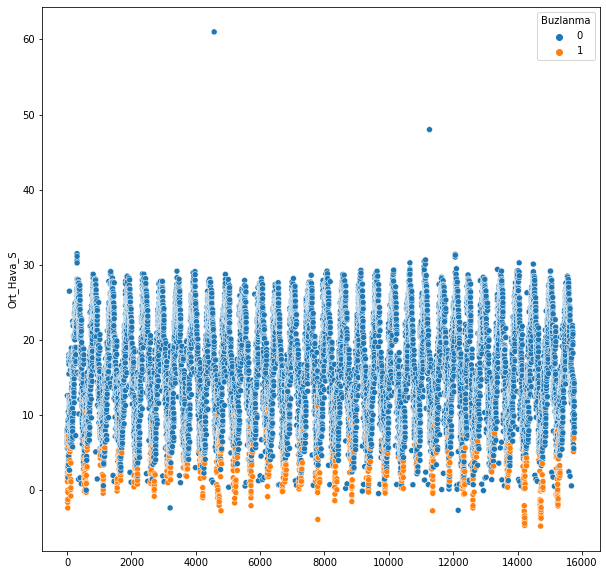

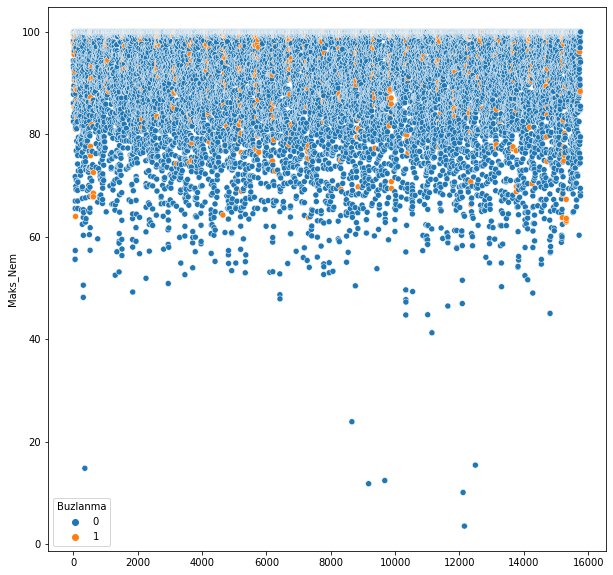

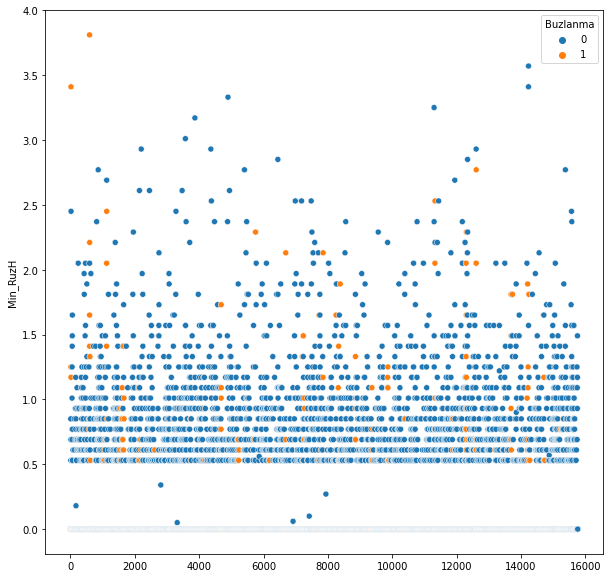

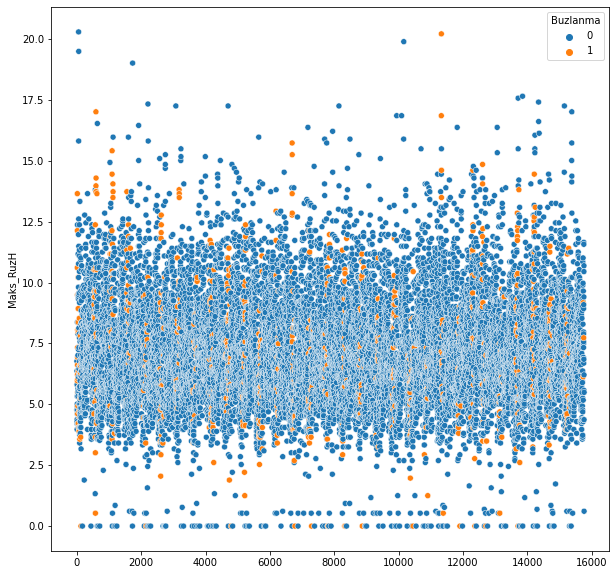

In [12]:
columns = ['Min_Hava_S', 'Maks_Hava_S', 'Ort_Hava_S', 'Maks_Nem', 'Min_RuzH', 'Maks_RuzH']

for column in columns:
    plt.figure(figsize= (10,10))
    sbn.scatterplot(data= df, x= range(len(df)), y= column, hue= 'Buzlanma')
    plt.show

In [13]:
columns = ['Min_Hava_S', 'Maks_Hava_S', 'Ort_Hava_S', 'Maks_Nem', 'Min_RuzH', 'Maks_RuzH', 'time_Month']

for column in columns:
    for snow in df['Buzlanma'].unique():
        selected_snow = df[df['Buzlanma'] == snow]
        selected_column = selected_snow[column]

        std = selected_column.std()
        avg = selected_column.mean()

        three_sigma_plus = avg + (3 * std)
        three_sigma_minus = avg - (3 * std)

        outliers = selected_column[((selected_snow[column] > three_sigma_plus) | (selected_snow[column] < three_sigma_minus))].index

        # df.iloc[outliers, df['Buzlanma']] = 1

        # if df['Buzlanma'].iloc[outliers].item == 0:
        df.drop(index= outliers, inplace= True)

## Sigma3 outlier algoritması ile outlier ları temizledim bu sayede daha temiz bir veri elde ettik.

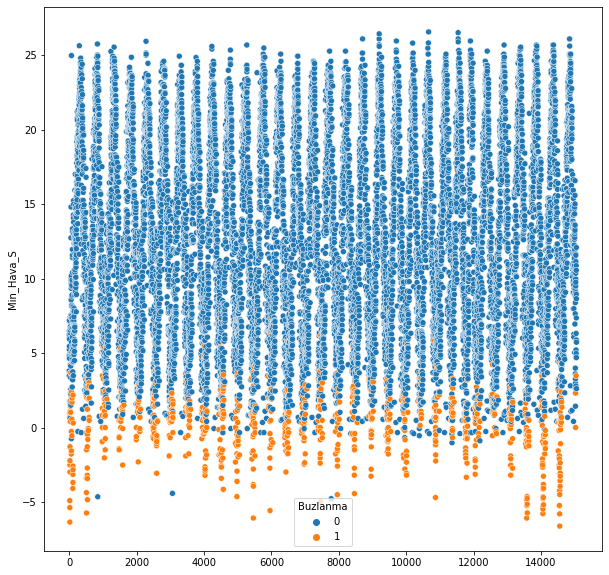

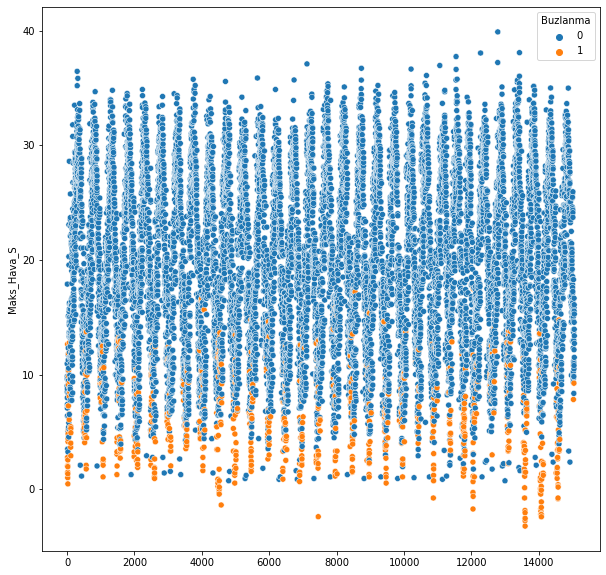

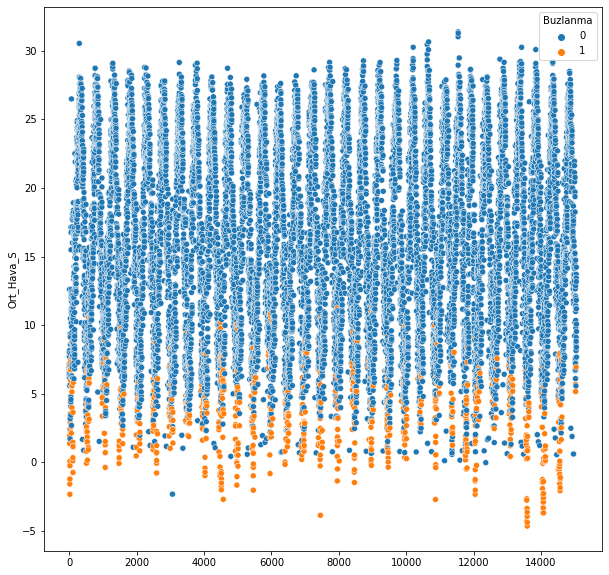

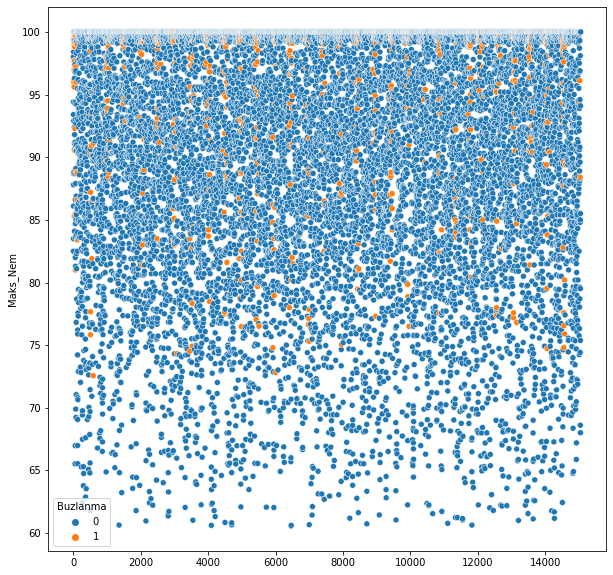

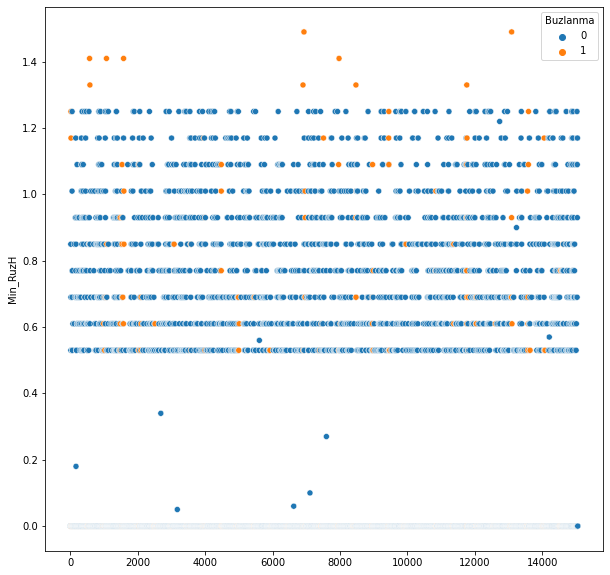

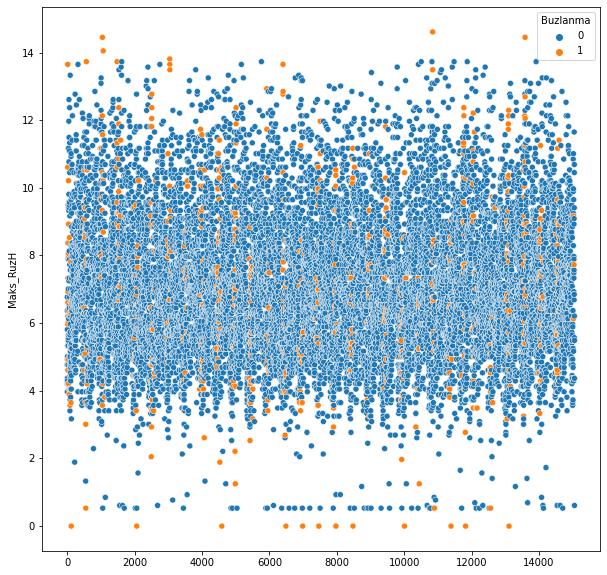

In [14]:
columns = ['Min_Hava_S', 'Maks_Hava_S', 'Ort_Hava_S', 'Maks_Nem', 'Min_RuzH', 'Maks_RuzH']

for column in columns:
    plt.figure(figsize= (10, 10))
    sbn.scatterplot(data= df, x= range(len(df)), y= column, hue= 'Buzlanma')
    plt.show

## Temizlenmiş verileri görselleştirdik daha iyi gözlemlemek için.

<Figure size 720x720 with 0 Axes>

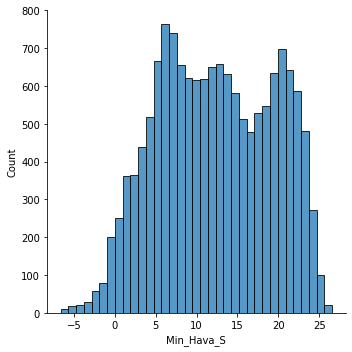

<Figure size 720x720 with 0 Axes>

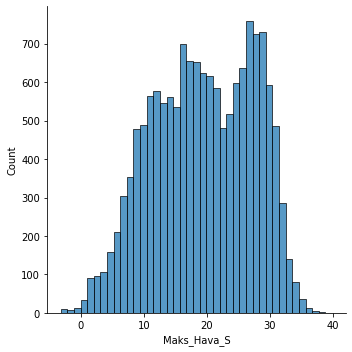

<Figure size 720x720 with 0 Axes>

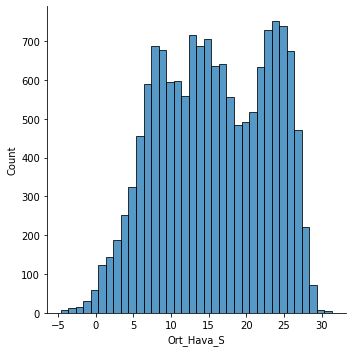

In [15]:
columns = ['Min_Hava_S', 'Maks_Hava_S', 'Ort_Hava_S']
for column in columns:
    plt.figure(figsize=(10,10))
    sbn.displot(df[column])
    plt.show()

<Figure size 720x720 with 0 Axes>

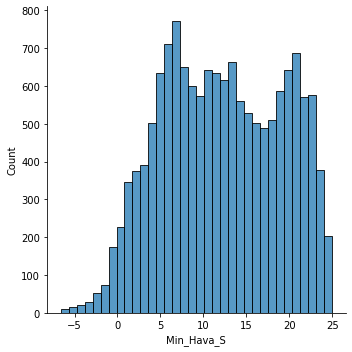

<Figure size 720x720 with 0 Axes>

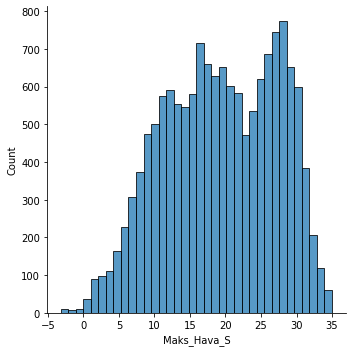

<Figure size 720x720 with 0 Axes>

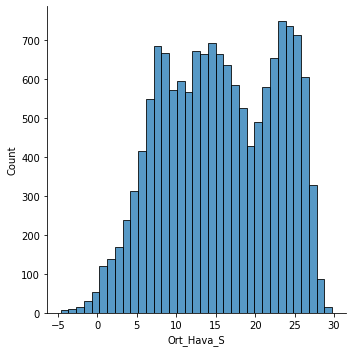

In [16]:
index1 = df[['Min_Hava_S','Buzlanma']][df['Min_Hava_S'] > 25]['Buzlanma'].index ## ==> 0 
index2 = df[['Maks_Hava_S','Buzlanma']][df['Maks_Hava_S'] > 35]['Buzlanma'].index ## ==> 0
index3 = df[['Ort_Hava_S','Buzlanma']][df['Ort_Hava_S'] > 30]['Buzlanma'].index ## ==> 0

def outlier(df, index):
    for i in index:
        try:
            df.drop(index= i, inplace= True)
        except:
            pass
        
    return 0   

outlier(df, index1)
outlier(df, index2)
outlier(df, index3)

columns = ['Min_Hava_S', 'Maks_Hava_S', 'Ort_Hava_S']
for column in columns:
    plt.figure(figsize=(10,10))
    sbn.displot(df[column])
    plt.show()


## Distplot ile kullandığım öznitelikleri çizdirdik ve veriyi dengelemek için outlier olarak gördüğüm değerlerden 0 olanları attık.

In [17]:
def train_test_validation_split(df, rate):
    train = int(len(df) - (len(df) * rate))
    # test = int((len(df) - train) * 0.3)
    # validation =  int(len(df) - (train + test)) + train
    
    return train

train = train_test_validation_split(df, 0.3)

In [18]:
x = df.drop(['Buzlanma'], axis= 1).values.astype('float')
y = df['Buzlanma'].values.astype('float')
x_train = x[:train]
# x_validation = x[train: val]
x_test = x[train:]
y_train = y[:train]
# y_validation = y[train:val]
y_test = y[train:]

## Verileri tarih bilgisine göre sıraladığım için bağımlı, bağımsız verileri rastgele seçmedik.
## Eski verileri train kümesine, günümüz verilerini ise test kümelesine dahil ettik.

In [19]:
print('y_train: ', np.unique(y_train, return_counts=True))
# print('y_train: ', np.unique(y_validation, return_counts=True))
print('y_test: ', np.unique(y_test, return_counts=True))

y_train:  (array([0., 1.]), array([9825,  640], dtype=int64))
y_test:  (array([0., 1.]), array([4236,  249], dtype=int64))


## Veri dağılımı gözlemledik.

In [20]:
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train)
# x_validation = StandardScaler().fit_transform(x_validation)
x_test = StandardScaler().fit_transform(x_test)

## Daha kısa sürede yakınsaması için verileri normalize ettik.

# ÖzNitelik Seçimi

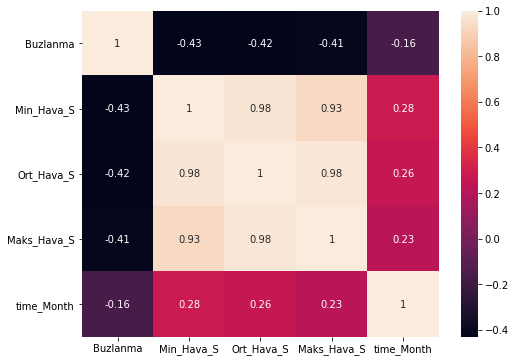

In [24]:
from sklearn.preprocessing import StandardScaler

best_feat = df.corr()['Buzlanma'].abs().nlargest(5).index

x_reduce = df[best_feat] ## Buzlanma kolonunu dışarda bırakmak için.
plt.figure(figsize=(8,6))
sbn.heatmap(x_reduce.corr(), annot=True)
plt.show()

y = df['Buzlanma'].values.astype('float')

xr_scaled = StandardScaler().fit_transform(x_reduce)


xr_train = xr_scaled[:train]
# xr_validation = xr_scaled[train:val]
xr_test = xr_scaled[train:]

## Hedeflenen özelliğe göre korolesyon matrisindeki mutlak olarak en yüksek 4 değeri seçtik.
## Uygulanması ve anlaşılması en kolay olması nedeni ile kullandık.
## Özelliklerimi seçtikden sonra yine train ve test olarak ayırdık. Ve standardize ettik.

# Metrik Secimi

## Bu veri setinde etiketlerde dengesizlik olduğu için accuracy değeri tek başına yanıltıcı olmaktadır.
## Bu veride baş etmemiz gereken kısım false-negative' ler dir bu yüzden recall metriğini öncelik olarak seçtik.

# Model Secimi

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek 

# smt = SMOTETomek(random_state=42)
# x_train_resampled, y_train_resampled = smt.fit_resample(xr_train, y_train)

# x_train_resampled, y_train_resampled = BorderlineSMOTE().fit_resample(xr_train, y_train)

# smote_nc = SMOTENC(categorical_features=[0, 1], random_state=0)
# x_train_resampled, y_train_resampled = smote_nc.fit_resample(xr_train, y_train)

# x_train_resampled, y_train_resampled = SMOTE().fit_resample(xr_train, y_train)

# x_train_resampled, y_train_resampled = ADASYN().fit_resample(xr_train, y_train)

ros = RandomOverSampler(sampling_strategy= 0.6) ## 0.6 iyi gibi
x_train_resampled, y_train_resampled = ros.fit_resample(xr_train, y_train)

## Etiket verisindeki dağılımın dengesizliğinden dolayı imblanced ile resampling algoritmalarını kullandık.
## Bu sayede dengesizlik ile mücadele ettik.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score

knn_model = KNeighborsClassifier().fit(x_train_resampled, y_train_resampled)
knn_preds = knn_model.predict(xr_test)

print('knn',recall_score(y_test,knn_preds))
print('knn',confusion_matrix(y_test,knn_preds))
print('knn',classification_report(y_test,knn_preds))

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier().fit(x_train_resampled, y_train_resampled)
sgd_preds = sgd.predict(xr_test)

print('clf',recall_score(y_test,sgd_preds))
print('clf',confusion_matrix(y_test,sgd_preds))
print('clf',classification_report(y_test,sgd_preds))

In [ ]:
from sklearn.svm import SVC
svc_linear_model = SVC(kernel= 'linear').fit(x_train_resampled, y_train_resampled)
svc_linear_preds = svc_linear_model.predict(xr_test)
print('linear',recall_score(y_test,svc_linear_preds))
print('linear',confusion_matrix(y_test,svc_linear_preds))
print('linear',classification_report(y_test,svc_linear_preds))

svc_poly_model = SVC(kernel= 'poly').fit(x_train_resampled, y_train_resampled)
svc_poly_preds = svc_poly_model.predict(xr_test)
print('poly',recall_score(y_test,svc_poly_preds))
print('poly',confusion_matrix(y_test,svc_poly_preds))
print('poly',classification_report(y_test,svc_poly_preds))

svc_rbf_model = SVC(kernel= 'rbf').fit(x_train_resampled, y_train_resampled) 
svc_rbf_preds = svc_rbf_model.predict(xr_test)
print('rbf',recall_score(y_test,svc_rbf_preds))
print('rbf',confusion_matrix(y_test,svc_rbf_preds))
print('rbf',classification_report(y_test,svc_rbf_preds))

In [ ]:
import xgboost as xgb

xgboost_model = xgb.XGBClassifier(objective= 'binary:logistic', use_label_encoder= False, eval_metric= None).fit(x_train_resampled, y_train_resampled)
xgboost_preds = xgboost_model.predict(xr_test)

print('xgboost',recall_score(y_test,xgboost_preds))
print('xgboost',confusion_matrix(y_test,xgboost_preds))
print('xgboost',classification_report(y_test,xgboost_preds))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier().fit(x_train_resampled,y_train_resampled)
random_forest_preds = random_forest_model.predict(xr_test)

print('random_forest',recall_score(y_test,random_forest_preds))
print('random_forest',confusion_matrix(y_test,random_forest_preds))
print('random_forest',classification_report(y_test,random_forest_preds))

## Algoritma seçimi için default hipermparametreler ile denemeler yaptık.
## Bu denemelerde en yüksek başarıma sahip algoritmaya seçmeyi hedefliyoruz.
## Burda değerlendirme metrik'i olarak sadece accuracy'i dikkate almadık veri dengesizliğinden dolayı.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.metrics import Recall

model = Sequential()

model.add(Dense(4,activation='relu')) ## 30 norön ilk katman alttakiler ara katmanlar
model.add(Dense(2,activation='relu'))

model.add(Dense(1,activation='sigmoid')) ## Çıkış katmanı

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics= Recall())

model.fit(x=x_train_resampled,y=y_train_resampled,validation_data=(xr_test,y_test),verbose=1,epochs=50) 

from keras.models import load_model
model.save('my_model.h5')

lossData = pd.DataFrame(model.history.history)
lossData.plot(figsize=(10,10))

# nn_preds = model.predict_classes(xr_test)
nn_preds = model.evaluate(xr_test, y_test)
nn_preds

# HiperParametre

In [ ]:
rbf = SVC(kernel= 'rbf')

params = [{'C':[100,200,300,400,500,600,700,800,900,1000],'kernel':['rbf'],'gamma': [0.01,0.02,0.03,0.04]}]

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# random_clf_acc = RandomizedSearchCV(estimator=rbf, param_distributions= params, n_iter= 10, verbose= 2, n_jobs= -1, scoring= 'recall',cv= 3)
# random_clf_acc.fit(x_train_resampled, y_train_resampled)

# y_pred_recall = grid_clf_acc.predict(xr_test)

# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))

# print(random_clf_acc.best_params_)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score


# grid_clf_acc = GridSearchCV(rbf, param_grid = params,scoring = 'recall', cv= 3)
# grid_clf_acc.fit(x_train_resampled, y_train_resampled)

# y_pred_recall = grid_clf_acc.predict(xr_test)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))

# print(grid_clf_acc.best_params_)

## 2 tane hiperparametre algoritması kullandım ama elle verdiğim değer daha iyi olduğu için bu algoritmaları kullanmadık.

In [ ]:
model = SVC(kernel= 'rbf', gamma= 0.3).fit(x_train_resampled, y_train_resampled) 
preds = model.predict(xr_test)
print('rbf',recall_score(y_test,preds))
print('rbf',confusion_matrix(y_test,preds))
print('rbf',classification_report(y_test,preds))

# Save Model

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib')
clf = load('model.joblib').predict(xr_test)
print(recall_score(y_test, clf))

## Modeli Predict Fonksiyonunda kullanmak üzere kayıt ettik.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import seaborn as seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from joblib import dump, load
from keras.models import load_model

def Tool(df, column, drop= True, Part= True): ## Sorted
    list = []
    for d in df[column]:
        day, month, year = d.split('.')
        if len(day) < 2:
            day = '0' + day
        time = f'{year}-{month}-{day}'
        list.append(time)   
    frame = pd.Series(list, name= 'time')
    frame = pd.to_datetime(frame) ## year, month, day
    frame = pd.DataFrame(frame, columns= ['time'])

    if drop:
        df.drop(column, axis= 1, inplace= True)

    df = pd.concat([df, frame], axis= 1)

    if Part:
        attr = ['Year', 'Month', 'Day']
        for a in attr:
            df['time' + f'_{a}'] = getattr(df['time'].dt, a.lower())    
    
    return df

def Predict(input_filename, model_filename): ## Veri_ID = indis
   df = pd.read_csv(f'{input_filename}.csv',sep=';') ## , skiprows=range(1,11036)
   df = Tool(df,'Veri_T')
   
   index = df['Veri_ID']

   x = df[['Min_Hava_S', 'Ort_Hava_S', 'Maks_Hava_S', 'time_Month']].values.astype('float')
   y = df['Buzlanma'].values.astype('float')

   x_scale = StandardScaler().fit_transform(x)
   
   preds = load(f'{model_filename}.joblib').predict(x_scale)
#    preds = load_model(f'{model_filename}.h5').predict_classes(x_scale)
   print('rbf_accuracy',accuracy_score(y,preds))
   print('rbf_recall',recall_score(y,preds))
   print('rbf',confusion_matrix(y,preds))
   print('rbf',classification_report(y,preds))

   df_preds = pd.DataFrame(preds, columns=['icing_prediction'])
   output_df = pd.concat([index, df_preds], axis= 1)

   return output_df.to_csv('output.csv', index= False)

predict = Predict('buzlanma_data','model')
predict   